In [1]:
!pip install mesa
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model 

# Debido a que necesitamos un solo agente por celda elegimos `SingleGrid` que fuerza un solo objeto por celda.
from mesa.space import MultiGrid

# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random

     |████████████████████████████████| 668 kB 5.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [31]:
#Función que sirve para capturar las posiciones y estados de los agentes en el modelo.
def get_grid(model):
  grid = np.zeros((model.grid.width, model.grid.height))
  
  for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    for obj in cell_content:
      if isinstance(obj, cleanerAgent):
        grid[x][y] = 2
      elif isinstance(obj, cellAgent):
        grid[x][y] = obj.clean

  return grid

#Agente de robots limpiadores.
class cleanerAgent(Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.sig_pos = None

  #Step del agente en el que se decide si se moverá o limpiara la celda actual
  def step(self):
    vecinos = self.model.grid.get_neighbors(
        self.pos,
        moore = True,
        include_center = True)
    
    #Revisa la celda actual y sus vecinos si la actual está sucia, no se mueve; pero si no lo está, se mueve a otra.
    for vecino in vecinos:
      if isinstance(vecino, cellAgent) and self.pos == vecino.pos:
        if vecino.clean == 1:
          vecino.sig_estado = 0
          self.sig_pos = self.pos
        else:
          vecinos2 = self.model.grid.get_neighborhood(
              self.pos,
              moore = True,
              include_center = False)
          vecino.sig_estado = 0
          self.sig_pos = self.random.choice(vecinos2)
        break

  #Ejecuta los movimientos realizados en step().
  def advance(self):
    vecinos = self.model.grid.get_neighbors(
        self.pos,
        moore = True,
        include_center = True)
    for vecino in vecinos:
      if isinstance(vecino, cellAgent) and self.pos == vecino.pos:
        vecino.clean = vecino.sig_estado
        break
    
    self.model.grid.move_agent(self, self.sig_pos)

#Agente de celdas en el modelo.
class cellAgent(Agent):
  def __init__(self, unique_id, model, estado):
    super().__init__(unique_id, model)
    self.pos = unique_id
    self.clean = estado
    self.sig_estado = None

#Modelo que incluye las celdas y los robots limpiadores.
class MyModel(Model):
  def __init__(self, width, height, N, P):
    self.num_agents = N
    self.percentage_dirty = P
    self.grid = MultiGrid(width, height, False)
    self.schedule = SimultaneousActivation(self)

    #Calcula la cantidad de celdas sucias a partir del tamaño del modelo y el porcentaje.
    num_celdas = int(width * height * P)

    #Popula el grid del modelo con celdas, decide si las celdas están sucias o no al azar.
    for (content, x, y) in self.grid.coord_iter():
      num = random.randint(0, 1)

      if num == 1 and num_celdas > 0:
        a = cellAgent((x, y), self, 1)
        num_celdas -= 1
      else:
        a = cellAgent((x, y), self, 0)

      self.grid.place_agent(a, (x, y))
      self.schedule.add(a)

    #Coloca los Agentes robots en la coordinada (1, 1)
    for i in range(self.num_agents):
      b = cleanerAgent(i, self)
      self.grid.place_agent(b, (1, 1))
      self.schedule.add(b)

    #Funcion que captura posiciones de agentes en cada step, hace referencia a get_grid()
    self.datacollector = DataCollector(
        model_reporters={"Grid": get_grid})
    
  #Step del Modelo.
  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()

In [32]:
M = 10 #width
N = 10 #height
num_agentes = 5
porc_celdas_sucias = 0.4
exec_time = 0.1
frame = 0

#Creación del modelo.
model = MyModel(M, N, num_agentes, porc_celdas)

start_time = time.time()

#Causa cambios en el modelo y captura cuantos steps se toman.
while(time.time() - start_time < exec_time):
  model.step()
  frame += 1

print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:00:00.100280


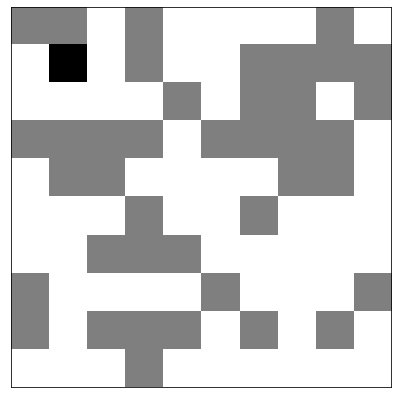

In [33]:
#Recolecta los cambios en los steps del modelo.
all_grid = model.datacollector.get_model_vars_dataframe()

#%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

#Crea una animación que muestra las steps del modelo.
def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=frame)

anim